In [ ]:
%%time
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re
import nltk
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)

CPU times: user 4.67 ms, sys: 0 ns, total: 4.67 ms
Wall time: 4.68 ms


In [ ]:
df = '/content/drive/MyDrive/NSU_Courses/CSE/CSE499A';
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/NSU_Courses/CSE/CSE499A/cuet_dataset.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for cols in df.columns:
    unique_vals = df[cols].unique()
    if len(unique_vals) <= 10:
        print("Feature ", cols, " has ", len(unique_vals), " unique values ----> ", unique_vals)
    else:
        print("Feature ", cols, " has ", len(unique_vals), " unique values")

Feature  Unnamed: 0  has  6243  unique values
Feature  cleaned  has  5669  unique values
Feature  classes  has  6  unique values ---->  ['sadness' 'disgust' 'fear' 'joy' 'surprise' 'anger']
Feature  labels  has  6  unique values ---->  [1 3 5 0 2 4]


In [ ]:
df.dropna(inplace=True)
df["classes"].value_counts()

disgust     1553
sadness     1190
joy         1142
fear         872
anger        759
surprise     727
Name: classes, dtype: int64

In [ ]:
## checking for null values
df.isnull().sum()

Unnamed: 0    0
cleaned       0
classes       0
labels        0
dtype: int64

In [ ]:
# remove duplicate entries, if any
df.drop_duplicates(inplace = True)
print(df.shape)

(6243, 4)


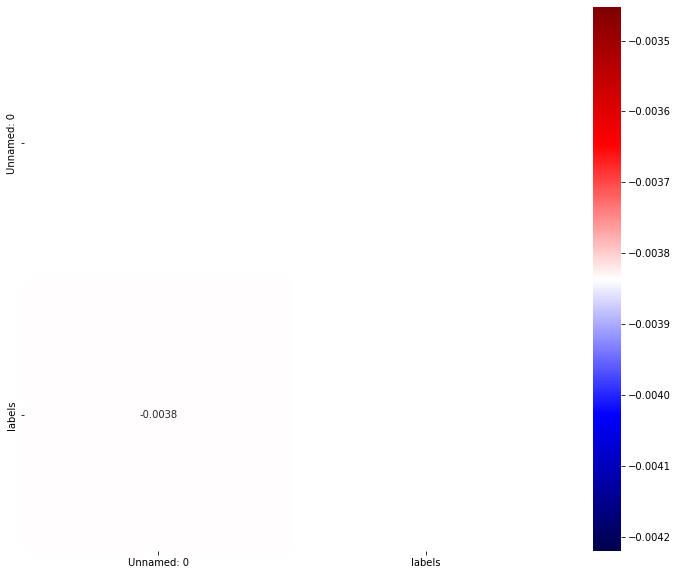

In [ ]:
# Pearson's Correlation Coefficient

corr = df.corr()
mask1 = np.triu(np.ones_like(corr, dtype=bool))
mask2 = np.tril(np.ones_like(corr, dtype=bool))
plt.figure(figsize = (12,10))
sns.heatmap(corr, annot = True, cmap = "seismic", mask = mask1);

In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is highly correlated with another feature

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of the redundant columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if(abs(corr_matrix.iloc[i, j])) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(df, 0.9) # 85% is a good value of the threshold
print(len(corr_features))
print(corr_features)

0
set()


In [ ]:
path = '/content/drive/MyDrive/NSU_Courses/CSE/CSE445/cse445_project/'
from google.colab import drive
drive.mount('/content/drive')
raw_train_data = pd.read_excel(path+'train.xlsx') 
raw_val_data = pd.read_excel(path + 'val.xlsx')
raw_test_data = pd.read_excel(path + 'test.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Creating training data
train_data = raw_train_data.cleaned.tolist()
train_labels = raw_train_data.labels.tolist()

#Creating validation data
val_data = raw_val_data.cleaned.tolist()
val_labels = raw_val_data.labels.tolist()

#Creating testing data
test_data = raw_test_data.cleaned.tolist()
test_labels = raw_test_data.labels.tolist()

In [ ]:
%%time
lr_model = LogisticRegressionCV(class_weight='balanced', max_iter=400)
dt_model = DecisionTreeClassifier(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced')
mnb_model = MultinomialNB()
svm_model = SVC(class_weight='balanced')
knn_model = KNeighborsClassifier()
ada_model = AdaBoostClassifier()
model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes', 'SVM', 'KNN', 'AdaBoost']
ml_models = [lr_model,dt_model,rf_model,mnb_model, svm_model, knn_model, ada_model]

CPU times: user 98 µs, sys: 86 µs, total: 184 µs
Wall time: 191 µs


In [ ]:
%%time
def model_train(model, train_data, train_labels):
  pipe = Pipeline([
        ('FE', TfidfVectorizer(ngram_range=(1,2), use_idf = True, tokenizer=lambda x: x.split(), max_features=20000)),  
        ('Transformer', TfidfTransformer()),  
        ('M', model)
    ])
  pipe.fit(train_data, train_labels)
  return pipe

trained_ml_models = []
for i in ml_models:
    tt = model_train(i,train_data, train_labels)
    trained_ml_models.append(tt)

CPU times: user 3min 51s, sys: 3min 36s, total: 7min 28s
Wall time: 4min 46s


# **Performance on validation set**

In [ ]:
pr_list = []
re_list = []
f1_list = []
acc_list = []

def print_results(md, x_test, y_test, name):
    print("\n\nClassifier: ", name)
    pred_y = md.predict(x_test)
    true, pred = y_test, pred_y
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred))
    print("\nPrecison : ",precision_score(pred,true, average = 'weighted'))
    print("\nRecall : ",recall_score(pred,true,  average = 'weighted'))
    print("\nF1 : ",f1_score(pred,true,  average = 'weighted'))
    print("\nAccuracy : ",accuracy_score(pred,true))

    pr_list.append((round(precision_score(y_test, pred_y, average='weighted'),4)*100)) 
    re_list.append((round(recall_score(y_test, pred_y, average='weighted'),4)*100))
    f1_list.append((round(f1_score(y_test, pred_y, average='weighted'),4)*100))
    acc_list.append((round(accuracy_score(y_test, pred_y),4)*100))

for i in range(len(trained_ml_models)):
    md = trained_ml_models[i]
    name = model_names[i]
    print_results(md, val_data, val_labels, name)

performance_matrix = pd.DataFrame({'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list, 'Accuracy':acc_list },
                                  index =model_names)
performance_matrix



Classifier:  Logistic Regression
[[ 80  17   7  10   3   3]
 [ 11  82  10   5  11  10]
 [  7   7  34   5   1  10]
 [  8   9   5 114  18   1]
 [  1  14   2  13  36   1]
 [  1  11   5   6   2  64]]
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       120
           1       0.59      0.64      0.61       129
           2       0.54      0.53      0.54        64
           3       0.75      0.74      0.74       155
           4       0.51      0.54      0.52        67
           5       0.72      0.72      0.72        89

    accuracy                           0.66       624
   macro avg       0.64      0.64      0.64       624
weighted avg       0.66      0.66      0.66       624


Precison :  0.6556719295695885

Recall :  0.657051282051282

F1 :  0.6557341915395648

Accuracy :  0.657051282051282


Classifier:  Decision Tree
[[47 18 15 22 13  5]
 [21 43 23 20 12 10]
 [ 7 19 22  9  3  4]
 [12 20  4 98 18  3]
 [11 12  2 11 26  5]
 [ 9 12

,Precision,Recall,F1 Score,Accuracy
Logistic Regression,66.10,65.71,65.84,65.71
Decision Tree,44.66,43.91,43.99,43.91
Random Forest,57.71,57.05,55.95,57.05
Naive Bayes,62.00,56.41,52.23,56.41
SVM,64.64,62.98,62.67,62.98
KNN,49.14,47.76,47.56,47.76
AdaBoost,49.67,44.07,43.06,44.07


# **Performance on test set**

In [ ]:
pr_list = []
re_list = []
f1_list = []
acc_list = []

def print_results(md, x_test, y_test, name):
    print("\n\nClassifier: ", name)
    pred_y = md.predict(x_test)
    true, pred = y_test, pred_y
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred))
    print("\nPrecison : ",precision_score(pred,true, average = 'weighted'))
    print("\nRecall : ",recall_score(pred,true,  average = 'weighted'))
    print("\nF1 : ",f1_score(pred,true,  average = 'weighted'))
    print("\nAccuracy : ",accuracy_score(pred,true))

    pr_list.append((round(precision_score(y_test, pred_y, average='weighted'),4)*100)) 
    re_list.append((round(recall_score(y_test, pred_y, average='weighted'),4)*100))
    f1_list.append((round(f1_score(y_test, pred_y, average='weighted'),4)*100))
    acc_list.append((round(accuracy_score(y_test, pred_y),4)*100))

for i in range(len(trained_ml_models)):
    md = trained_ml_models[i]
    name = model_names[i]
    print_results(md, test_data, test_labels, name)

performance_matrix = pd.DataFrame({'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list, 'Accuracy':acc_list},
                                  index =model_names)
performance_matrix



Classifier:  Logistic Regression
[[ 83   6  15   6   2   2]
 [ 13  65   5  14  13   9]
 [  8   9  38   6   5   7]
 [ 13  14   6 105  24   3]
 [  3   4   5  23  32   4]
 [  4   7   6   4   6  56]]
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       114
           1       0.62      0.55      0.58       119
           2       0.51      0.52      0.51        73
           3       0.66      0.64      0.65       165
           4       0.39      0.45      0.42        71
           5       0.69      0.67      0.68        83

    accuracy                           0.61       625
   macro avg       0.59      0.59      0.59       625
weighted avg       0.61      0.61      0.61       625


Precison :  0.6061256676083742

Recall :  0.6064

F1 :  0.6052489495061344

Accuracy :  0.6064


Classifier:  Decision Tree
[[ 48  19  11  20  12   4]
 [ 21  44  11  18  16   9]
 [ 12  13  26  13   3   6]
 [ 15  17   7 100  21   5]
 [ 11  14  10  14  20   2]

,Precision,Recall,F1 Score,Accuracy
Logistic Regression,61.07,60.64,60.76,60.64
Decision Tree,44.77,44.32,44.42,44.32
Random Forest,55.33,54.56,52.66,54.56
Naive Bayes,64.24,54.08,48.68,54.08
SVM,61.13,60.00,59.54,60.00
KNN,44.55,44.64,44.07,44.64
AdaBoost,48.72,42.40,40.76,42.40


In [ ]:
plt.plot(range, x_test, 'ro-', range, y_test,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy');

index = 0
for i in range:
    print("K = ", range[index], ", Training Accuracy = ", x_test[index], " Test Accuracy = ", y_test[index], 
          ", Difference = ", np.abs(x_test[index]-y_test[index])*100, "%")
    index+=1

NameError: ignored

In [ ]:
def PlotGraph(model_train):
    acc = history.model_train['accuracy']
    val_acc = history.model_train['val_accuracy']
    loss = history.model_train['loss']
    val_loss = history.model_train['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
PlotGraph(history)

NameError: ignored

# **Ensemble**

In [ ]:
whole_data = []

def make_whole_list(L):
  for i in L:
    whole_data.append(i)

make_whole_list(train_data)
make_whole_list(val_data)
make_whole_list(test_data)
print(len(whole_data))

6243


In [ ]:
tf = TfidfVectorizer(ngram_range=(1,2), use_idf = True, tokenizer=lambda x: x.split(),  max_features=20000)
tf.fit_transform(whole_data) ### Bit confusion arises here need to resolve
trained_texts = tf.transform(train_data)
val_texts = tf.transform(val_data)
test_texts = tf.transform(test_data)

In [ ]:
%%time
from sklearn.ensemble import VotingClassifier
LogReg_clf = LogisticRegressionCV(class_weight='balanced', max_iter=400)
rt_clf =   RandomForestClassifier(class_weight='balanced')
SVC_clf = SVC(class_weight='balanced')


voting_clf = VotingClassifier(estimators=[('SVC', SVC_clf), ('LogReg', LogReg_clf),('RF', rt_clf)], voting='hard')
voting_clf.fit(trained_texts, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


CPU times: user 4min 2s, sys: 3min 53s, total: 7min 55s
Wall time: 4min 28s


# **val set**

In [ ]:
preds = voting_clf.predict(val_texts)
true, pred = val_labels, preds
print(confusion_matrix(true,pred))
print(classification_report(true,pred))
print("\nPrecison : ",precision_score(true, pred, average = 'weighted'))
print("\nRecall : ",recall_score(true, pred,  average = 'weighted'))
print("\nF1 : ",f1_score(true, pred,  average = 'weighted'))

[[ 80  18   5  15   1   1]
 [ 14  86   6  13   6   4]
 [  8  11  30   8   0   7]
 [  7  10   3 124  10   1]
 [  5  11   2  14  34   1]
 [  5  13   2  10   2  57]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       120
           1       0.58      0.67      0.62       129
           2       0.62      0.47      0.54        64
           3       0.67      0.80      0.73       155
           4       0.64      0.51      0.57        67
           5       0.80      0.64      0.71        89

    accuracy                           0.66       624
   macro avg       0.67      0.62      0.64       624
weighted avg       0.66      0.66      0.66       624


Precison :  0.6634887865167364

Recall :  0.6586538461538461

F1 :  0.6557770657205486


# **test set**

In [ ]:
preds = voting_clf.predict(test_texts)
true, pred = test_labels, preds
print(confusion_matrix(true,pred))
print(classification_report(true,pred))
print("\nPrecison : ",precision_score(true, pred, average = 'weighted'))
print("\nRecall : ",recall_score(true, pred,  average = 'weighted'))
print("\nF1 : ",f1_score(true, pred,  average = 'weighted'))

[[ 92   7   5  10   0   0]
 [ 15  65   2  22   7   8]
 [ 11  14  27  10   3   8]
 [ 13  16   4 116  14   2]
 [  9  10   2  26  22   2]
 [  6  12   3   7   1  54]]
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       114
           1       0.52      0.55      0.53       119
           2       0.63      0.37      0.47        73
           3       0.61      0.70      0.65       165
           4       0.47      0.31      0.37        71
           5       0.73      0.65      0.69        83

    accuracy                           0.60       625
   macro avg       0.60      0.56      0.57       625
weighted avg       0.60      0.60      0.59       625


Precison :  0.5985006275252399

Recall :  0.6016

F1 :  0.5910727051168683
